##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Basic training loops

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/basic_training_loops"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In the previous guides, you have learned about [tensors](./tensor.ipynb), [variables](./variable.ipynb), [gradient tape](autodiff.ipynb), and [modules](./intro_to_modules.ipynb).  In this guide, you will fit these all together to train models.

TensorFlow also includes the [tf.Keras API](https://www.tensorflow.org/guide/keras/overview), a high-level neural network API that provides useful abstractions to reduce boilerplate.  However, in this guide, you will use basic classes.

## Setup

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Solving machine learning problems

Solving a machine learning problem usually consists of the following steps:

 - Obtain training data.
 - Define the model.
 - Define a loss function.
 - Run through the training data, calculating loss from the ideal value
 - Calculate gradients for that loss and use an *optimizer* to adjust the variables to fit the data.
 - Evaluate your results.

For illustration purposes, in this guide you'll develop a simple linear model, $f(x) = x * W + b$, which has two variables: $W$ (weights) and $b$ (bias).

This is the most basic of machine learning problems:  Given $x$ and $y$, try to find the slope and offset of a line via  [simple linear regression](https://en.wikipedia.org/wiki/Linear_regression#Simple_and_multiple_linear_regression).

## Data

Supervised learning uses *inputs* (usually denoted as *x*) and *outputs* (denoted *y*, often called *labels*).  The goal is to learn from paired inputs and outputs so that you can predict the value of an output from an input.

Each input of your data, in TensorFlow, is almost always represented by a tensor, and is often a vector. In supervised training, the output (or value you'd like to predict) is also a tensor.

Here is some data synthesized by adding Gaussian (Normal) noise to points along a line.

In [3]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2,2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

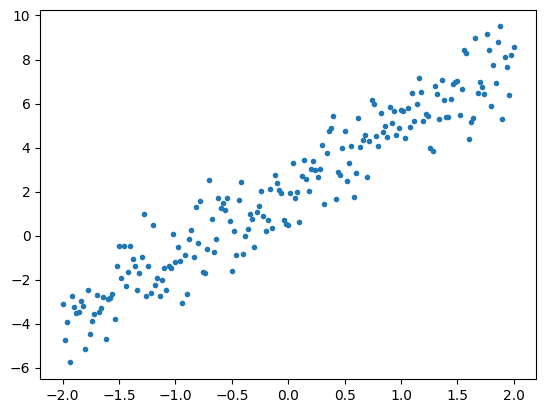

In [4]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()

Tensors are usually gathered together in *batches*, or groups of inputs and outputs stacked together.  Batching can confer some training benefits and works well with accelerators and vectorized computation.  Given how small this dataset is, you can treat the entire dataset as a single batch.

## Define the model

Use `tf.Variable` to represent all weights in a model.  A `tf.Variable` stores a value and provides this in tensor form as needed.  See the [variable guide](./variable.ipynb) for more details.

Use `tf.Module` to encapsulate the variables and the computation.  You could use any Python object, but this way it can be easily saved.

Here, you define both *w* and *b* as variables.

In [5]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


The initial variables are set here in a fixed way, but Keras comes with any of a number of [initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) you could use, with or without the rest of Keras.

### Define a loss function

A loss function measures how well the output of a model for a given input matches the target output. The goal is to minimize this difference during training. Define the standard L2 loss, also known as the "mean squared" error:

In [6]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

Before training the model, you can visualize the loss value by plotting the model's predictions in red and the training data in blue:

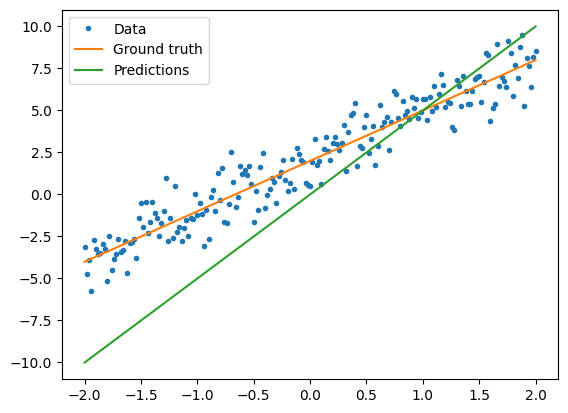

Current loss: 10.725492


In [7]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(y, model(x)).numpy())

### Define a training loop

The training loop consists of repeatedly doing three tasks in order:

* Sending a batch of inputs through the model to generate outputs
* Calculating the loss by comparing the outputs to the output (or label)
* Using gradient tape to find the gradients
* Optimizing the variables with those gradients

For this example, you can train the model using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).

There are many variants of the gradient descent scheme that are captured in `tf.keras.optimizers`. But in the spirit of building from first principles, here you will implement the basic math yourself with the help of `tf.GradientTape` for automatic differentiation and `tf.assign_sub` for decrementing a value (which combines `tf.assign` and `tf.sub`):

In [8]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

For a look at training, you can send the same batch of *x* and *y* through the training loop, and see how `W` and `b` evolve.

In [9]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

# Define a training loop
def report(model, loss):
  return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"


def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    weights.append(model.w.numpy())
    biases.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print(f"Epoch {epoch:2d}:")
    print("    ", report(model, current_loss))

Do the training

In [10]:
current_loss = loss(y, model(x))

print(f"Starting:")
print("    ", report(model, current_loss))

training_loop(model, x, y)

Starting:
     W = 5.00, b = 0.00, loss=10.72549
Epoch  0:
     W = 4.46, b = 0.41, loss=6.70816
Epoch  1:
     W = 4.07, b = 0.74, loss=4.40306
Epoch  2:
     W = 3.78, b = 1.00, loss=3.06981
Epoch  3:
     W = 3.57, b = 1.21, loss=2.29235
Epoch  4:
     W = 3.42, b = 1.38, loss=1.83525
Epoch  5:
     W = 3.31, b = 1.51, loss=1.56431
Epoch  6:
     W = 3.22, b = 1.62, loss=1.40245
Epoch  7:
     W = 3.16, b = 1.70, loss=1.30501
Epoch  8:
     W = 3.12, b = 1.77, loss=1.24594
Epoch  9:
     W = 3.09, b = 1.83, loss=1.20989


Plot the evolution of the weights over time:

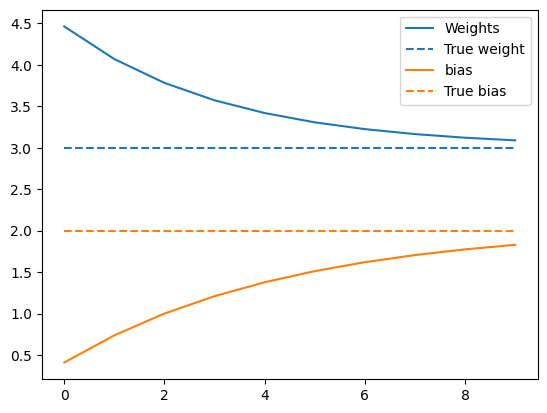

In [11]:
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

Visualize how the trained model performs

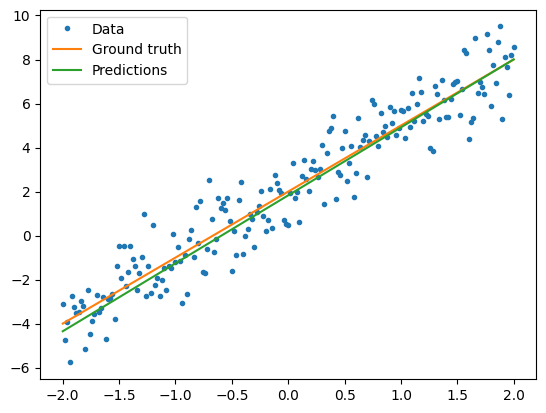

Current loss: 1.209895


In [12]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

## The same solution, but with Keras

It's useful to contrast the code above with the equivalent in Keras.

Defining the model looks exactly the same if you subclass `tf.keras.Model`.  Remember that Keras models inherit ultimately from module.

In [13]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("my_checkpoint")

Epoch  0:
     W = 4.46, b = 0.41, loss=6.70816
Epoch  1:
     W = 4.07, b = 0.74, loss=4.40306
Epoch  2:
     W = 3.78, b = 1.00, loss=3.06981
Epoch  3:
     W = 3.57, b = 1.21, loss=2.29235
Epoch  4:
     W = 3.42, b = 1.38, loss=1.83525
Epoch  5:
     W = 3.31, b = 1.51, loss=1.56431
Epoch  6:
     W = 3.22, b = 1.62, loss=1.40245
Epoch  7:
     W = 3.16, b = 1.70, loss=1.30501
Epoch  8:
     W = 3.12, b = 1.77, loss=1.24594
Epoch  9:
     W = 3.09, b = 1.83, loss=1.20989


Rather than write new training loops each time you create a model, you can use the built-in features of Keras as a shortcut.  This can be useful when you do not want to write or debug Python training loops.

If you do, you will need to use `model.compile()` to set the parameters, and `model.fit()` to train.  It can be less code to use Keras implementations of L2 loss and gradient descent, again as a shortcut.  Keras losses and optimizers can be used outside of these convenience functions, too, and the previous example could have used them.

In [14]:
keras_model = MyModelKeras()

# compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

Keras `fit` expects batched data or a complete dataset as a NumPy array.  NumPy arrays are chopped into batches and default to a batch size of 32.

In this case, to match the behavior of the hand-written loop, you should pass `x` in as a single batch of size 1000.

In [15]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

201
Epoch 1/10
1/1 [==============================] - 0s 248ms/step - loss: 10.7255
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 6.7082
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 4.4031
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 3.0698
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 2.2923
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 1.8352
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 1.5643
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 1.4024
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 1.3050
Epoch 10/10
1/1 [==============================] - 0s 4ms/step - loss: 1.2459


Note that Keras prints out the loss after training, not before, so the first loss appears lower, but otherwise this shows essentially the same training performance.

## Next steps

In this guide, you have seen how to use the core classes of tensors, variables, modules, and gradient tape to build and train a model, and further how those ideas map to Keras.

This is, however, an extremely simple problem. For a more practical introduction, see [Custom training walkthrough](../tutorials/customization/custom_training_walkthrough.ipynb).

For more on using built-in Keras training loops, see [this guide](https://www.tensorflow.org/guide/keras/train_and_evaluate).  For more on training loops and Keras, see [this guide](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).  For writing custom distributed training loops, see [this guide](distributed_training.ipynb#using_tfdistributestrategy_with_basic_training_loops_loops).